# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
%matplotlib inline

import helper
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
import problem_unittests as tests
import tensorflow as tf
import warnings

from distutils.version import LooseVersion
from glob import glob
from matplotlib import pyplot

print('All imports successful, ready to rip!')

All imports successful, ready to rip!


In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

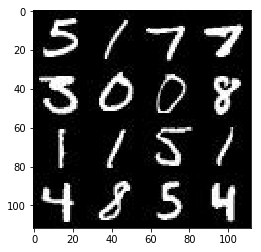

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

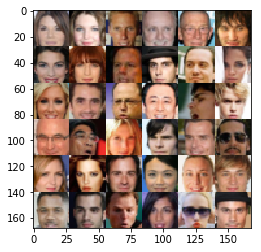

In [4]:
show_n_images = 40

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),  name = 'input_real')
    z = tf.placeholder(tf.float32, (None, z_dim),  name = 'input_z')
    lr = tf.placeholder(tf.float32, name = 'learning_rate_t')
    return image, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
D_NAME = 'discriminator'

def discriminator(images, reuse = False, alpha = .2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope(D_NAME, reuse = reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        # Training is always true because we are only interested in using the generator.
        # If need be, can set to false if we need to use this for inference
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flattened = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flattened, 1)
        activation_output = tf.sigmoid(logits)
        return activation_output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
G_NAME = 'generator'

def generator(z, out_channel_dim, is_train = True, alpha = .2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope(G_NAME, reuse = not is_train):
        x1 = tf.layers.dense(z, 2 * 2 * 512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(x1, training = is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides = 2, padding = 'valid')
        bn2 = tf.layers.batch_normalization(x2, training = is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides = 2, padding = 'same')
        # 28x28xout_channel_dim
        output_activation = tf.tanh(logits)
        return output_activation


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha = .2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train = True)
    
    d_model_real, d_logits_real = discriminator(input_real, alpha = alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True, alpha = alpha)
    
    d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                                          labels = tf.ones_like(d_model_real))
    d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                          labels = tf.zeros_like(d_model_fake))
    
    g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                     labels = tf.ones_like(d_model_fake))

    g_loss = tf.reduce_mean(g_loss)
    d_loss_real = tf.reduce_mean(d_loss_real)
    d_loss_fake = tf.reduce_mean(d_loss_fake)
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
  
    t_vars = tf.trainable_variables()
    d_vars = [tf_var for tf_var in t_vars if tf_var.name.startswith(D_NAME)]
    g_vars = [tf_var for tf_var in t_vars if tf_var.name.startswith(G_NAME)]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1)
        d_train_op = optimizer.minimize(d_loss, var_list = d_vars)
        g_train_op = optimizer.minimize(g_loss, var_list = g_vars)

        return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def show_generator_output(sess, input_z, out_channel_dim, image_mode, example_z):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    :param example_z: A fixed, but random, set of inputs (rather than generating from scratch each time)
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    #z_dim = input_z.get_shape().as_list()[-1]
    #example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    #pyplot.figure(figsize=(8, 8))
    pyplot.imshow(images_grid, cmap=cmap, aspect='equal')
    pyplot.show()
    
    return samples

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def model_inputs_from_shape(data_shape, z_dim):
                   # image_width, image_height, image_channels, z_dim
    return model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

def train(epoch_count, batch_size, z_dim, learning_rate, beta1,
          get_batches, data_shape, data_image_mode,
          print_every = 10, show_every = 100,
          num_images_to_sample = 18,
          train_discriminator_every_N_steps = 2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    out_channel_dim = data_shape[3]
    input_real, input_z, lr_tensor = model_inputs_from_shape(data_shape, z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_op, g_train_op = model_opt(d_loss, g_loss, lr_tensor, beta1)

    saver = tf.train.Saver()
    
    # We would prefer to use the same 'randomized' input so we can compare output over training time...
    sample_z = np.random.uniform(-1, 1, size=(num_images_to_sample, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2 # per https://discussions.udacity.com/t/need-help-with-final-project-discrimnator-loss-much-lower-than-the-generator-one/400443
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                if steps % train_discriminator_every_N_steps == 0: # original GAN paper mentioned certain number of times to train g vs d.
                    sess.run(d_train_op, feed_dict = {input_real: batch_images, input_z: batch_z, lr_tensor: learning_rate})
                sess.run(g_train_op, feed_dict = {input_real: batch_images, input_z: batch_z, lr_tensor: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print('Step {}, Epoch {}/{}'.format(steps, epoch_i + 1, epoch_count),
                          'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                          'Geneator Loss: {:.4f}'.format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    gen_samples = show_generator_output(sess, input_z,
                                          out_channel_dim, data_image_mode, sample_z)
                    samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
    
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
        
    
    return losses, samples      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 10, Epoch 1/2 Discriminator Loss: 0.6604... Geneator Loss: 3.4703
Step 20, Epoch 1/2 Discriminator Loss: 0.4563... Geneator Loss: 1.4596
Step 30, Epoch 1/2 Discriminator Loss: 0.7811... Geneator Loss: 7.5967
Step 40, Epoch 1/2 Discriminator Loss: 0.6567... Geneator Loss: 6.0827
Step 50, Epoch 1/2 Discriminator Loss: 0.3228... Geneator Loss: 5.3346
Step 60, Epoch 1/2 Discriminator Loss: 0.3301... Geneator Loss: 5.6305
Step 70, Epoch 1/2 Discriminator Loss: 1.5252... Geneator Loss: 5.7530
Step 80, Epoch 1/2 Discriminator Loss: 0.6539... Geneator Loss: 1.6115
Step 90, Epoch 1/2 Discriminator Loss: 0.7569... Geneator Loss: 3.9623
Step 100, Epoch 1/2 Discriminator Loss: 2.3369... Geneator Loss: 1.4224


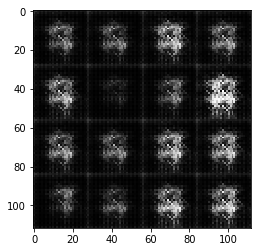

Step 110, Epoch 1/2 Discriminator Loss: 0.5113... Geneator Loss: 3.3205
Step 120, Epoch 1/2 Discriminator Loss: 0.5227... Geneator Loss: 1.9647
Step 130, Epoch 1/2 Discriminator Loss: 0.8611... Geneator Loss: 1.5330
Step 140, Epoch 1/2 Discriminator Loss: 0.4138... Geneator Loss: 2.4806
Step 150, Epoch 1/2 Discriminator Loss: 0.2712... Geneator Loss: 2.9325
Step 160, Epoch 1/2 Discriminator Loss: 0.7115... Geneator Loss: 5.7223
Step 170, Epoch 1/2 Discriminator Loss: 1.2384... Geneator Loss: 0.6063
Step 180, Epoch 1/2 Discriminator Loss: 0.3895... Geneator Loss: 3.3712
Step 190, Epoch 1/2 Discriminator Loss: 0.4075... Geneator Loss: 3.9837
Step 200, Epoch 1/2 Discriminator Loss: 0.4665... Geneator Loss: 2.2240


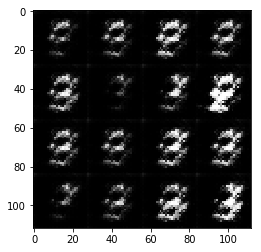

Step 210, Epoch 1/2 Discriminator Loss: 0.4187... Geneator Loss: 2.6110
Step 220, Epoch 1/2 Discriminator Loss: 0.3814... Geneator Loss: 2.1997
Step 230, Epoch 1/2 Discriminator Loss: 0.2192... Geneator Loss: 2.1302
Step 240, Epoch 1/2 Discriminator Loss: 0.3456... Geneator Loss: 3.0596
Step 250, Epoch 1/2 Discriminator Loss: 0.2059... Geneator Loss: 3.8950
Step 260, Epoch 1/2 Discriminator Loss: 0.2503... Geneator Loss: 2.8694
Step 270, Epoch 1/2 Discriminator Loss: 0.8464... Geneator Loss: 5.2109
Step 280, Epoch 1/2 Discriminator Loss: 0.5260... Geneator Loss: 2.7439
Step 290, Epoch 1/2 Discriminator Loss: 0.7969... Geneator Loss: 3.4555
Step 300, Epoch 1/2 Discriminator Loss: 0.5402... Geneator Loss: 2.3727


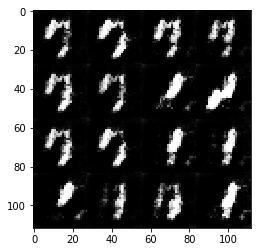

Step 310, Epoch 1/2 Discriminator Loss: 0.3893... Geneator Loss: 2.4530
Step 320, Epoch 1/2 Discriminator Loss: 0.3688... Geneator Loss: 3.1313
Step 330, Epoch 1/2 Discriminator Loss: 0.3957... Geneator Loss: 2.4357
Step 340, Epoch 1/2 Discriminator Loss: 0.6549... Geneator Loss: 2.7481
Step 350, Epoch 1/2 Discriminator Loss: 0.4935... Geneator Loss: 2.2251
Step 360, Epoch 1/2 Discriminator Loss: 0.3529... Geneator Loss: 3.0055
Step 370, Epoch 1/2 Discriminator Loss: 0.3515... Geneator Loss: 2.8032
Step 380, Epoch 1/2 Discriminator Loss: 0.3511... Geneator Loss: 2.8505
Step 390, Epoch 1/2 Discriminator Loss: 0.7045... Geneator Loss: 3.4478
Step 400, Epoch 1/2 Discriminator Loss: 0.2742... Geneator Loss: 2.6499


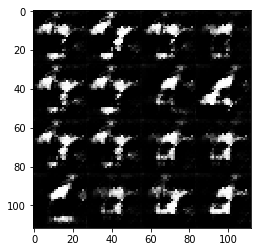

Step 410, Epoch 1/2 Discriminator Loss: 0.6229... Geneator Loss: 3.9564
Step 420, Epoch 1/2 Discriminator Loss: 0.4612... Geneator Loss: 2.7038
Step 430, Epoch 1/2 Discriminator Loss: 0.4510... Geneator Loss: 1.8400
Step 440, Epoch 1/2 Discriminator Loss: 0.6214... Geneator Loss: 3.0549
Step 450, Epoch 1/2 Discriminator Loss: 0.4038... Geneator Loss: 2.7900
Step 460, Epoch 1/2 Discriminator Loss: 0.5731... Geneator Loss: 2.5584
Step 470, Epoch 1/2 Discriminator Loss: 0.5283... Geneator Loss: 2.0661
Step 480, Epoch 1/2 Discriminator Loss: 0.5301... Geneator Loss: 1.9820
Step 490, Epoch 1/2 Discriminator Loss: 0.8032... Geneator Loss: 1.3755
Step 500, Epoch 1/2 Discriminator Loss: 0.7211... Geneator Loss: 2.6587


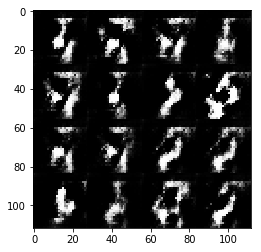

Step 510, Epoch 1/2 Discriminator Loss: 1.0694... Geneator Loss: 1.0344
Step 520, Epoch 1/2 Discriminator Loss: 0.7457... Geneator Loss: 2.0900
Step 530, Epoch 1/2 Discriminator Loss: 0.5340... Geneator Loss: 2.4602
Step 540, Epoch 1/2 Discriminator Loss: 0.6608... Geneator Loss: 2.0469
Step 550, Epoch 1/2 Discriminator Loss: 0.7155... Geneator Loss: 2.7456
Step 560, Epoch 1/2 Discriminator Loss: 0.8895... Geneator Loss: 1.6647
Step 570, Epoch 1/2 Discriminator Loss: 0.7714... Geneator Loss: 2.3080
Step 580, Epoch 1/2 Discriminator Loss: 0.6444... Geneator Loss: 1.6976
Step 590, Epoch 1/2 Discriminator Loss: 0.7779... Geneator Loss: 1.4087
Step 600, Epoch 1/2 Discriminator Loss: 0.5162... Geneator Loss: 2.8392


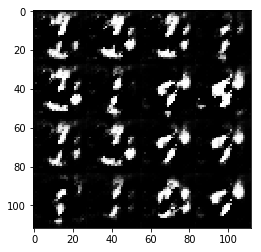

Step 610, Epoch 1/2 Discriminator Loss: 0.6707... Geneator Loss: 1.4393
Step 620, Epoch 1/2 Discriminator Loss: 0.7763... Geneator Loss: 1.4816
Step 630, Epoch 1/2 Discriminator Loss: 0.8709... Geneator Loss: 1.3644
Step 640, Epoch 1/2 Discriminator Loss: 0.5877... Geneator Loss: 1.8192
Step 650, Epoch 1/2 Discriminator Loss: 0.4974... Geneator Loss: 2.3719
Step 660, Epoch 1/2 Discriminator Loss: 0.8056... Geneator Loss: 1.9855
Step 670, Epoch 1/2 Discriminator Loss: 0.6442... Geneator Loss: 2.1331
Step 680, Epoch 1/2 Discriminator Loss: 0.6941... Geneator Loss: 2.0224
Step 690, Epoch 1/2 Discriminator Loss: 0.8242... Geneator Loss: 1.0334
Step 700, Epoch 1/2 Discriminator Loss: 0.7741... Geneator Loss: 1.4446


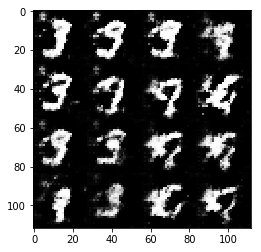

Step 710, Epoch 1/2 Discriminator Loss: 0.9174... Geneator Loss: 1.8350
Step 720, Epoch 1/2 Discriminator Loss: 0.5432... Geneator Loss: 2.4675
Step 730, Epoch 1/2 Discriminator Loss: 0.6126... Geneator Loss: 2.2887
Step 740, Epoch 1/2 Discriminator Loss: 0.5125... Geneator Loss: 1.8962
Step 750, Epoch 1/2 Discriminator Loss: 0.9421... Geneator Loss: 2.2460
Step 760, Epoch 1/2 Discriminator Loss: 0.5813... Geneator Loss: 2.4286
Step 770, Epoch 1/2 Discriminator Loss: 0.7810... Geneator Loss: 1.0747
Step 780, Epoch 1/2 Discriminator Loss: 0.5503... Geneator Loss: 2.2834
Step 790, Epoch 1/2 Discriminator Loss: 0.6336... Geneator Loss: 2.0281
Step 800, Epoch 1/2 Discriminator Loss: 0.7485... Geneator Loss: 1.0553


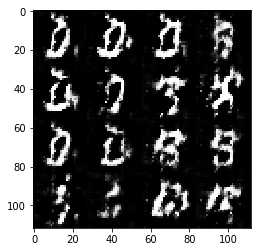

Step 810, Epoch 1/2 Discriminator Loss: 0.6690... Geneator Loss: 1.4028
Step 820, Epoch 1/2 Discriminator Loss: 0.6661... Geneator Loss: 2.1113
Step 830, Epoch 1/2 Discriminator Loss: 0.6550... Geneator Loss: 2.1513
Step 840, Epoch 1/2 Discriminator Loss: 0.5366... Geneator Loss: 2.1466
Step 850, Epoch 1/2 Discriminator Loss: 0.6748... Geneator Loss: 2.3869
Step 860, Epoch 1/2 Discriminator Loss: 0.5043... Geneator Loss: 2.6641
Step 870, Epoch 1/2 Discriminator Loss: 0.6826... Geneator Loss: 2.1031
Step 880, Epoch 1/2 Discriminator Loss: 0.7637... Geneator Loss: 1.5848
Step 890, Epoch 1/2 Discriminator Loss: 0.6849... Geneator Loss: 1.5090
Step 900, Epoch 1/2 Discriminator Loss: 0.6097... Geneator Loss: 1.7632


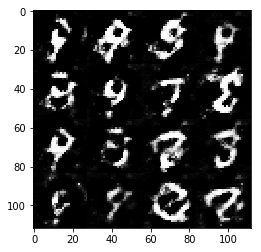

Step 910, Epoch 1/2 Discriminator Loss: 0.6978... Geneator Loss: 1.9264
Step 920, Epoch 1/2 Discriminator Loss: 0.6951... Geneator Loss: 1.9152
Step 930, Epoch 1/2 Discriminator Loss: 1.0372... Geneator Loss: 2.7498
Step 940, Epoch 2/2 Discriminator Loss: 0.9321... Geneator Loss: 2.1889
Step 950, Epoch 2/2 Discriminator Loss: 0.7350... Geneator Loss: 1.4361
Step 960, Epoch 2/2 Discriminator Loss: 0.7534... Geneator Loss: 1.0435
Step 970, Epoch 2/2 Discriminator Loss: 1.0705... Geneator Loss: 0.6947
Step 980, Epoch 2/2 Discriminator Loss: 0.6996... Geneator Loss: 1.8205
Step 990, Epoch 2/2 Discriminator Loss: 0.8057... Geneator Loss: 1.8802
Step 1000, Epoch 2/2 Discriminator Loss: 0.8008... Geneator Loss: 1.6541


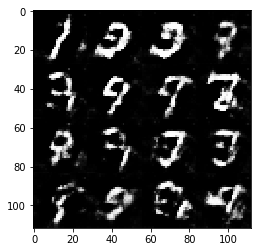

Step 1010, Epoch 2/2 Discriminator Loss: 1.2270... Geneator Loss: 0.7627
Step 1020, Epoch 2/2 Discriminator Loss: 0.6985... Geneator Loss: 1.3669
Step 1030, Epoch 2/2 Discriminator Loss: 0.9177... Geneator Loss: 1.3157
Step 1040, Epoch 2/2 Discriminator Loss: 0.7473... Geneator Loss: 1.1949
Step 1050, Epoch 2/2 Discriminator Loss: 0.9062... Geneator Loss: 0.8393
Step 1060, Epoch 2/2 Discriminator Loss: 0.9478... Geneator Loss: 1.6799
Step 1070, Epoch 2/2 Discriminator Loss: 1.0254... Geneator Loss: 1.6541
Step 1080, Epoch 2/2 Discriminator Loss: 0.8511... Geneator Loss: 1.2152
Step 1090, Epoch 2/2 Discriminator Loss: 0.9370... Geneator Loss: 0.9410
Step 1100, Epoch 2/2 Discriminator Loss: 0.9993... Geneator Loss: 2.1903


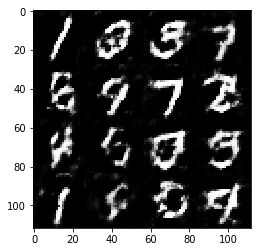

Step 1110, Epoch 2/2 Discriminator Loss: 0.9350... Geneator Loss: 1.2036
Step 1120, Epoch 2/2 Discriminator Loss: 0.9597... Geneator Loss: 0.8857
Step 1130, Epoch 2/2 Discriminator Loss: 1.0481... Geneator Loss: 1.7150
Step 1140, Epoch 2/2 Discriminator Loss: 0.8065... Geneator Loss: 1.7168
Step 1150, Epoch 2/2 Discriminator Loss: 1.0375... Geneator Loss: 1.6062
Step 1160, Epoch 2/2 Discriminator Loss: 0.9575... Geneator Loss: 0.8866
Step 1170, Epoch 2/2 Discriminator Loss: 0.7764... Geneator Loss: 1.7058
Step 1180, Epoch 2/2 Discriminator Loss: 0.8624... Geneator Loss: 1.2413
Step 1190, Epoch 2/2 Discriminator Loss: 0.9100... Geneator Loss: 0.8227
Step 1200, Epoch 2/2 Discriminator Loss: 0.9725... Geneator Loss: 1.6083


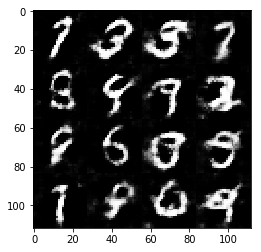

Step 1210, Epoch 2/2 Discriminator Loss: 0.8045... Geneator Loss: 0.9568
Step 1220, Epoch 2/2 Discriminator Loss: 0.9313... Geneator Loss: 1.0487
Step 1230, Epoch 2/2 Discriminator Loss: 0.7112... Geneator Loss: 1.3681
Step 1240, Epoch 2/2 Discriminator Loss: 0.9080... Geneator Loss: 1.1874
Step 1250, Epoch 2/2 Discriminator Loss: 0.8874... Geneator Loss: 1.9817
Step 1260, Epoch 2/2 Discriminator Loss: 0.9769... Geneator Loss: 0.7936
Step 1270, Epoch 2/2 Discriminator Loss: 1.1078... Geneator Loss: 1.9615
Step 1280, Epoch 2/2 Discriminator Loss: 0.8892... Geneator Loss: 1.8007
Step 1290, Epoch 2/2 Discriminator Loss: 0.8820... Geneator Loss: 1.3692
Step 1300, Epoch 2/2 Discriminator Loss: 1.0028... Geneator Loss: 1.5355


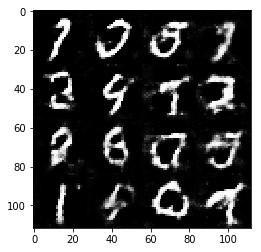

Step 1310, Epoch 2/2 Discriminator Loss: 0.9479... Geneator Loss: 0.9332
Step 1320, Epoch 2/2 Discriminator Loss: 0.9455... Geneator Loss: 1.6665
Step 1330, Epoch 2/2 Discriminator Loss: 1.1497... Geneator Loss: 0.6058
Step 1340, Epoch 2/2 Discriminator Loss: 0.9046... Geneator Loss: 0.9192
Step 1350, Epoch 2/2 Discriminator Loss: 0.8759... Geneator Loss: 1.8153
Step 1360, Epoch 2/2 Discriminator Loss: 1.0111... Geneator Loss: 0.7751
Step 1370, Epoch 2/2 Discriminator Loss: 0.8605... Geneator Loss: 1.4527
Step 1380, Epoch 2/2 Discriminator Loss: 1.0929... Geneator Loss: 0.6197
Step 1390, Epoch 2/2 Discriminator Loss: 0.9622... Geneator Loss: 1.7891
Step 1400, Epoch 2/2 Discriminator Loss: 1.2177... Geneator Loss: 1.9496


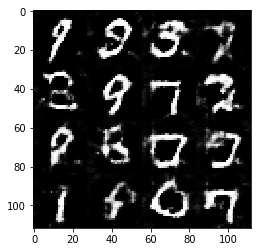

Step 1410, Epoch 2/2 Discriminator Loss: 1.0758... Geneator Loss: 0.8927
Step 1420, Epoch 2/2 Discriminator Loss: 1.0037... Geneator Loss: 1.3968
Step 1430, Epoch 2/2 Discriminator Loss: 1.2526... Geneator Loss: 0.5738
Step 1440, Epoch 2/2 Discriminator Loss: 1.0467... Geneator Loss: 1.3844
Step 1450, Epoch 2/2 Discriminator Loss: 0.9943... Geneator Loss: 1.4174
Step 1460, Epoch 2/2 Discriminator Loss: 0.9226... Geneator Loss: 0.9757
Step 1470, Epoch 2/2 Discriminator Loss: 0.9599... Geneator Loss: 0.9317
Step 1480, Epoch 2/2 Discriminator Loss: 0.9771... Geneator Loss: 0.8723
Step 1490, Epoch 2/2 Discriminator Loss: 0.8365... Geneator Loss: 1.3519
Step 1500, Epoch 2/2 Discriminator Loss: 1.1584... Geneator Loss: 0.5695


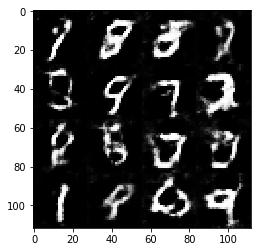

Step 1510, Epoch 2/2 Discriminator Loss: 1.0699... Geneator Loss: 0.9865
Step 1520, Epoch 2/2 Discriminator Loss: 1.1247... Geneator Loss: 1.2409
Step 1530, Epoch 2/2 Discriminator Loss: 1.4738... Geneator Loss: 2.3380
Step 1540, Epoch 2/2 Discriminator Loss: 1.0946... Geneator Loss: 1.3169
Step 1550, Epoch 2/2 Discriminator Loss: 0.9557... Geneator Loss: 1.1289
Step 1560, Epoch 2/2 Discriminator Loss: 1.0880... Geneator Loss: 1.5425
Step 1570, Epoch 2/2 Discriminator Loss: 0.9603... Geneator Loss: 1.2034
Step 1580, Epoch 2/2 Discriminator Loss: 1.0539... Geneator Loss: 1.9505
Step 1590, Epoch 2/2 Discriminator Loss: 0.8840... Geneator Loss: 1.3017
Step 1600, Epoch 2/2 Discriminator Loss: 1.0586... Geneator Loss: 0.7009


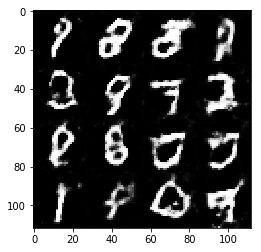

Step 1610, Epoch 2/2 Discriminator Loss: 1.0822... Geneator Loss: 0.6714
Step 1620, Epoch 2/2 Discriminator Loss: 0.8996... Geneator Loss: 0.9740
Step 1630, Epoch 2/2 Discriminator Loss: 1.0473... Geneator Loss: 0.8354
Step 1640, Epoch 2/2 Discriminator Loss: 0.9908... Geneator Loss: 0.7320
Step 1650, Epoch 2/2 Discriminator Loss: 1.3002... Geneator Loss: 1.4075
Step 1660, Epoch 2/2 Discriminator Loss: 1.0416... Geneator Loss: 1.1364
Step 1670, Epoch 2/2 Discriminator Loss: 1.4062... Geneator Loss: 0.4148
Step 1680, Epoch 2/2 Discriminator Loss: 1.0941... Geneator Loss: 1.1675
Step 1690, Epoch 2/2 Discriminator Loss: 1.0421... Geneator Loss: 0.7842
Step 1700, Epoch 2/2 Discriminator Loss: 0.9568... Geneator Loss: 0.9960


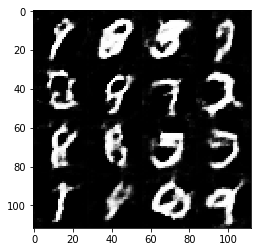

Step 1710, Epoch 2/2 Discriminator Loss: 1.0579... Geneator Loss: 0.6929
Step 1720, Epoch 2/2 Discriminator Loss: 0.9770... Geneator Loss: 1.1946
Step 1730, Epoch 2/2 Discriminator Loss: 0.9704... Geneator Loss: 0.9641
Step 1740, Epoch 2/2 Discriminator Loss: 1.1351... Geneator Loss: 1.7238
Step 1750, Epoch 2/2 Discriminator Loss: 1.0196... Geneator Loss: 0.7006
Step 1760, Epoch 2/2 Discriminator Loss: 1.0193... Geneator Loss: 0.8706
Step 1770, Epoch 2/2 Discriminator Loss: 1.4268... Geneator Loss: 0.3959
Step 1780, Epoch 2/2 Discriminator Loss: 1.1456... Geneator Loss: 1.1768
Step 1790, Epoch 2/2 Discriminator Loss: 1.0355... Geneator Loss: 0.7581
Step 1800, Epoch 2/2 Discriminator Loss: 0.9062... Geneator Loss: 1.0344


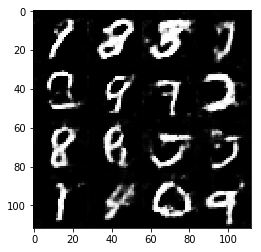

Step 1810, Epoch 2/2 Discriminator Loss: 1.1251... Geneator Loss: 1.0707
Step 1820, Epoch 2/2 Discriminator Loss: 1.1936... Geneator Loss: 0.4986
Step 1830, Epoch 2/2 Discriminator Loss: 1.0081... Geneator Loss: 0.7834
Step 1840, Epoch 2/2 Discriminator Loss: 1.1851... Geneator Loss: 1.3299
Step 1850, Epoch 2/2 Discriminator Loss: 1.3535... Geneator Loss: 0.4214
Step 1860, Epoch 2/2 Discriminator Loss: 1.0078... Geneator Loss: 0.9971
Step 1870, Epoch 2/2 Discriminator Loss: 1.1500... Geneator Loss: 0.5455
all done!


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

losses = []
samples = []
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1,
                            mnist_dataset.get_batches,
                            mnist_dataset.shape, mnist_dataset.image_mode)
    
print('all done!')

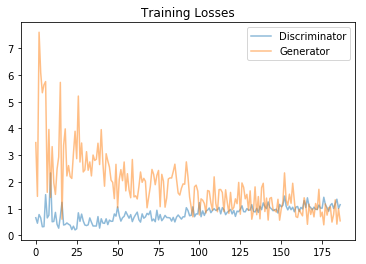

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 10, Epoch 1/1 Discriminator Loss: 2.2231... Geneator Loss: 0.2438
Step 20, Epoch 1/1 Discriminator Loss: 1.2578... Geneator Loss: 6.1622
Step 30, Epoch 1/1 Discriminator Loss: 0.7768... Geneator Loss: 1.9923
Step 40, Epoch 1/1 Discriminator Loss: 0.6474... Geneator Loss: 6.6781
Step 50, Epoch 1/1 Discriminator Loss: 0.4139... Geneator Loss: 2.4560
Step 60, Epoch 1/1 Discriminator Loss: 0.8004... Geneator Loss: 7.4206
Step 70, Epoch 1/1 Discriminator Loss: 0.6458... Geneator Loss: 3.6714
Step 80, Epoch 1/1 Discriminator Loss: 1.1634... Geneator Loss: 4.5311
Step 90, Epoch 1/1 Discriminator Loss: 2.9701... Geneator Loss: 5.3595
Step 100, Epoch 1/1 Discriminator Loss: 0.5343... Geneator Loss: 3.5710


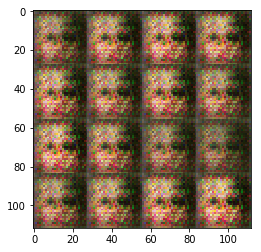

Step 110, Epoch 1/1 Discriminator Loss: 1.1541... Geneator Loss: 2.9761
Step 120, Epoch 1/1 Discriminator Loss: 0.6931... Geneator Loss: 4.4430
Step 130, Epoch 1/1 Discriminator Loss: 1.0940... Geneator Loss: 3.7500
Step 140, Epoch 1/1 Discriminator Loss: 1.1483... Geneator Loss: 2.8829
Step 150, Epoch 1/1 Discriminator Loss: 0.9318... Geneator Loss: 1.8302
Step 160, Epoch 1/1 Discriminator Loss: 0.8957... Geneator Loss: 1.6325
Step 170, Epoch 1/1 Discriminator Loss: 1.1008... Geneator Loss: 1.0634
Step 180, Epoch 1/1 Discriminator Loss: 0.9185... Geneator Loss: 1.6515
Step 190, Epoch 1/1 Discriminator Loss: 0.7865... Geneator Loss: 1.3571
Step 200, Epoch 1/1 Discriminator Loss: 1.0775... Geneator Loss: 1.3319


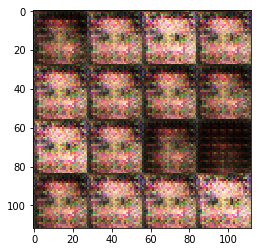

Step 210, Epoch 1/1 Discriminator Loss: 1.0524... Geneator Loss: 1.2378
Step 220, Epoch 1/1 Discriminator Loss: 1.5082... Geneator Loss: 1.2852
Step 230, Epoch 1/1 Discriminator Loss: 1.1553... Geneator Loss: 1.9849
Step 240, Epoch 1/1 Discriminator Loss: 1.1208... Geneator Loss: 1.8048
Step 250, Epoch 1/1 Discriminator Loss: 1.2250... Geneator Loss: 1.1369
Step 260, Epoch 1/1 Discriminator Loss: 1.7557... Geneator Loss: 0.9175
Step 270, Epoch 1/1 Discriminator Loss: 1.6605... Geneator Loss: 1.0108
Step 280, Epoch 1/1 Discriminator Loss: 1.0597... Geneator Loss: 1.3024
Step 290, Epoch 1/1 Discriminator Loss: 1.2766... Geneator Loss: 1.4111
Step 300, Epoch 1/1 Discriminator Loss: 1.4139... Geneator Loss: 0.9178


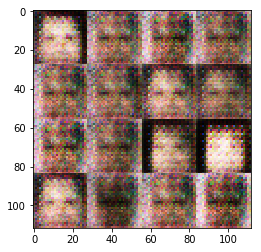

Step 310, Epoch 1/1 Discriminator Loss: 0.9388... Geneator Loss: 1.2329
Step 320, Epoch 1/1 Discriminator Loss: 1.1759... Geneator Loss: 1.3301
Step 330, Epoch 1/1 Discriminator Loss: 1.5763... Geneator Loss: 0.9554
Step 340, Epoch 1/1 Discriminator Loss: 1.6779... Geneator Loss: 0.7718
Step 350, Epoch 1/1 Discriminator Loss: 1.6007... Geneator Loss: 0.8182
Step 360, Epoch 1/1 Discriminator Loss: 1.6110... Geneator Loss: 0.7186
Step 370, Epoch 1/1 Discriminator Loss: 1.6307... Geneator Loss: 0.7996
Step 380, Epoch 1/1 Discriminator Loss: 1.5790... Geneator Loss: 0.7133
Step 390, Epoch 1/1 Discriminator Loss: 1.4076... Geneator Loss: 0.7717
Step 400, Epoch 1/1 Discriminator Loss: 1.1695... Geneator Loss: 1.1184


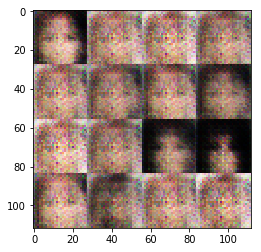

Step 410, Epoch 1/1 Discriminator Loss: 1.4530... Geneator Loss: 0.8030
Step 420, Epoch 1/1 Discriminator Loss: 1.4323... Geneator Loss: 0.6549
Step 430, Epoch 1/1 Discriminator Loss: 1.3393... Geneator Loss: 1.0035
Step 440, Epoch 1/1 Discriminator Loss: 1.0318... Geneator Loss: 1.0385
Step 450, Epoch 1/1 Discriminator Loss: 1.6151... Geneator Loss: 0.7642
Step 460, Epoch 1/1 Discriminator Loss: 1.2868... Geneator Loss: 0.9241
Step 470, Epoch 1/1 Discriminator Loss: 1.3228... Geneator Loss: 1.0459
Step 480, Epoch 1/1 Discriminator Loss: 1.4543... Geneator Loss: 1.0028
Step 490, Epoch 1/1 Discriminator Loss: 1.1741... Geneator Loss: 1.2838
Step 500, Epoch 1/1 Discriminator Loss: 1.5274... Geneator Loss: 0.8430


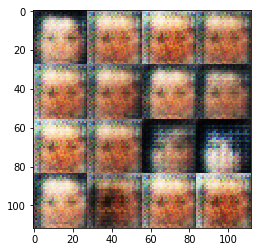

Step 510, Epoch 1/1 Discriminator Loss: 1.0443... Geneator Loss: 1.1293
Step 520, Epoch 1/1 Discriminator Loss: 1.0941... Geneator Loss: 0.9989
Step 530, Epoch 1/1 Discriminator Loss: 1.2822... Geneator Loss: 0.8969
Step 540, Epoch 1/1 Discriminator Loss: 1.1126... Geneator Loss: 0.9391
Step 550, Epoch 1/1 Discriminator Loss: 1.1442... Geneator Loss: 0.9948
Step 560, Epoch 1/1 Discriminator Loss: 1.0839... Geneator Loss: 1.0019
Step 570, Epoch 1/1 Discriminator Loss: 1.2630... Geneator Loss: 0.8400
Step 580, Epoch 1/1 Discriminator Loss: 1.0244... Geneator Loss: 1.1103
Step 590, Epoch 1/1 Discriminator Loss: 1.3576... Geneator Loss: 0.8725
Step 600, Epoch 1/1 Discriminator Loss: 1.1960... Geneator Loss: 1.0216


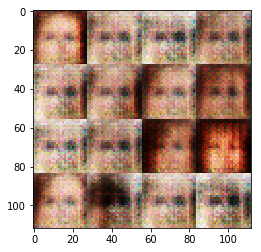

Step 610, Epoch 1/1 Discriminator Loss: 1.3055... Geneator Loss: 0.9888
Step 620, Epoch 1/1 Discriminator Loss: 1.1985... Geneator Loss: 0.9834
Step 630, Epoch 1/1 Discriminator Loss: 1.1970... Geneator Loss: 0.8824
Step 640, Epoch 1/1 Discriminator Loss: 1.2579... Geneator Loss: 1.0194
Step 650, Epoch 1/1 Discriminator Loss: 1.5383... Geneator Loss: 0.8403
Step 660, Epoch 1/1 Discriminator Loss: 1.2288... Geneator Loss: 0.9880
Step 670, Epoch 1/1 Discriminator Loss: 1.4768... Geneator Loss: 0.8002
Step 680, Epoch 1/1 Discriminator Loss: 1.3273... Geneator Loss: 0.9277
Step 690, Epoch 1/1 Discriminator Loss: 1.2951... Geneator Loss: 1.0390
Step 700, Epoch 1/1 Discriminator Loss: 1.2415... Geneator Loss: 0.9056


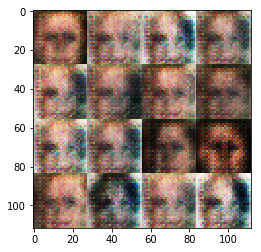

Step 710, Epoch 1/1 Discriminator Loss: 1.2721... Geneator Loss: 0.9185
Step 720, Epoch 1/1 Discriminator Loss: 1.2430... Geneator Loss: 0.9576
Step 730, Epoch 1/1 Discriminator Loss: 1.2249... Geneator Loss: 1.0215
Step 740, Epoch 1/1 Discriminator Loss: 1.4057... Geneator Loss: 0.8625
Step 750, Epoch 1/1 Discriminator Loss: 1.4328... Geneator Loss: 0.8403
Step 760, Epoch 1/1 Discriminator Loss: 1.3488... Geneator Loss: 0.7920
Step 770, Epoch 1/1 Discriminator Loss: 1.4310... Geneator Loss: 0.7689
Step 780, Epoch 1/1 Discriminator Loss: 1.1944... Geneator Loss: 0.9369
Step 790, Epoch 1/1 Discriminator Loss: 1.3672... Geneator Loss: 0.8069
Step 800, Epoch 1/1 Discriminator Loss: 1.4472... Geneator Loss: 0.6878


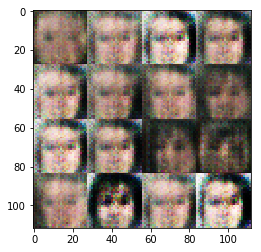

Step 810, Epoch 1/1 Discriminator Loss: 1.4069... Geneator Loss: 0.8147
Step 820, Epoch 1/1 Discriminator Loss: 1.3540... Geneator Loss: 0.8154
Step 830, Epoch 1/1 Discriminator Loss: 1.2528... Geneator Loss: 0.8661
Step 840, Epoch 1/1 Discriminator Loss: 1.2334... Geneator Loss: 0.8020
Step 850, Epoch 1/1 Discriminator Loss: 1.4539... Geneator Loss: 0.8271
Step 860, Epoch 1/1 Discriminator Loss: 1.3358... Geneator Loss: 0.8495
Step 870, Epoch 1/1 Discriminator Loss: 1.0516... Geneator Loss: 0.9411
Step 880, Epoch 1/1 Discriminator Loss: 1.5030... Geneator Loss: 0.9311
Step 890, Epoch 1/1 Discriminator Loss: 1.4407... Geneator Loss: 0.8910
Step 900, Epoch 1/1 Discriminator Loss: 1.2214... Geneator Loss: 0.9033


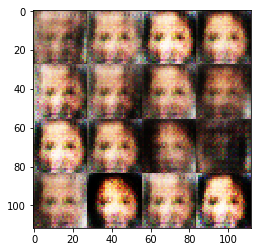

Step 910, Epoch 1/1 Discriminator Loss: 1.2694... Geneator Loss: 0.9169
Step 920, Epoch 1/1 Discriminator Loss: 1.2034... Geneator Loss: 0.9744
Step 930, Epoch 1/1 Discriminator Loss: 1.4386... Geneator Loss: 0.7257
Step 940, Epoch 1/1 Discriminator Loss: 1.3057... Geneator Loss: 0.7745
Step 950, Epoch 1/1 Discriminator Loss: 1.2404... Geneator Loss: 0.9324
Step 960, Epoch 1/1 Discriminator Loss: 1.2983... Geneator Loss: 0.8978
Step 970, Epoch 1/1 Discriminator Loss: 1.1295... Geneator Loss: 1.0206
Step 980, Epoch 1/1 Discriminator Loss: 1.3354... Geneator Loss: 0.8821
Step 990, Epoch 1/1 Discriminator Loss: 1.1247... Geneator Loss: 0.8720
Step 1000, Epoch 1/1 Discriminator Loss: 1.4357... Geneator Loss: 0.8453


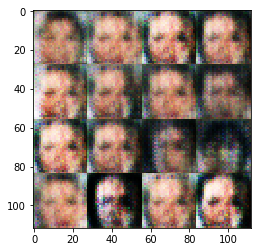

Step 1010, Epoch 1/1 Discriminator Loss: 1.2230... Geneator Loss: 0.9058
Step 1020, Epoch 1/1 Discriminator Loss: 1.2654... Geneator Loss: 0.8412
Step 1030, Epoch 1/1 Discriminator Loss: 1.4382... Geneator Loss: 0.7747
Step 1040, Epoch 1/1 Discriminator Loss: 1.3987... Geneator Loss: 0.7751
Step 1050, Epoch 1/1 Discriminator Loss: 1.3126... Geneator Loss: 0.8134
Step 1060, Epoch 1/1 Discriminator Loss: 1.3677... Geneator Loss: 0.7451
Step 1070, Epoch 1/1 Discriminator Loss: 1.1634... Geneator Loss: 0.9900
Step 1080, Epoch 1/1 Discriminator Loss: 1.3786... Geneator Loss: 0.7907
Step 1090, Epoch 1/1 Discriminator Loss: 1.2882... Geneator Loss: 0.9979
Step 1100, Epoch 1/1 Discriminator Loss: 1.2149... Geneator Loss: 0.8587


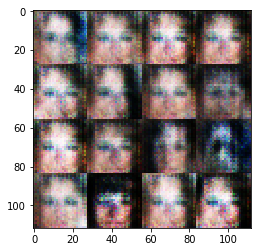

Step 1110, Epoch 1/1 Discriminator Loss: 1.3064... Geneator Loss: 0.8756
Step 1120, Epoch 1/1 Discriminator Loss: 1.2545... Geneator Loss: 1.0113
Step 1130, Epoch 1/1 Discriminator Loss: 1.0600... Geneator Loss: 1.0033
Step 1140, Epoch 1/1 Discriminator Loss: 1.6543... Geneator Loss: 0.5783
Step 1150, Epoch 1/1 Discriminator Loss: 1.3196... Geneator Loss: 0.8559
Step 1160, Epoch 1/1 Discriminator Loss: 1.3624... Geneator Loss: 0.8073
Step 1170, Epoch 1/1 Discriminator Loss: 1.3768... Geneator Loss: 0.8113
Step 1180, Epoch 1/1 Discriminator Loss: 1.3506... Geneator Loss: 0.7365
Step 1190, Epoch 1/1 Discriminator Loss: 1.4836... Geneator Loss: 0.7004
Step 1200, Epoch 1/1 Discriminator Loss: 1.3467... Geneator Loss: 0.8071


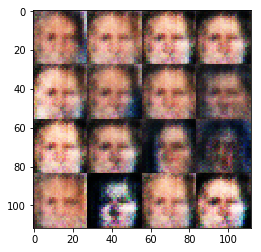

Step 1210, Epoch 1/1 Discriminator Loss: 1.2421... Geneator Loss: 0.8264
Step 1220, Epoch 1/1 Discriminator Loss: 1.2523... Geneator Loss: 0.8881
Step 1230, Epoch 1/1 Discriminator Loss: 1.3319... Geneator Loss: 0.8026
Step 1240, Epoch 1/1 Discriminator Loss: 1.4350... Geneator Loss: 0.7590
Step 1250, Epoch 1/1 Discriminator Loss: 1.2622... Geneator Loss: 0.8995
Step 1260, Epoch 1/1 Discriminator Loss: 1.6097... Geneator Loss: 0.7087
Step 1270, Epoch 1/1 Discriminator Loss: 1.5708... Geneator Loss: 0.7603
Step 1280, Epoch 1/1 Discriminator Loss: 1.2935... Geneator Loss: 0.8663
Step 1290, Epoch 1/1 Discriminator Loss: 1.4077... Geneator Loss: 0.8267
Step 1300, Epoch 1/1 Discriminator Loss: 1.3924... Geneator Loss: 0.7504


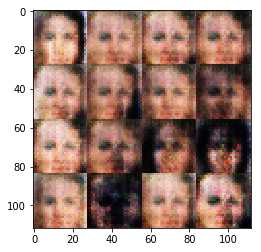

Step 1310, Epoch 1/1 Discriminator Loss: 1.1707... Geneator Loss: 0.8214
Step 1320, Epoch 1/1 Discriminator Loss: 1.3998... Geneator Loss: 0.7343
Step 1330, Epoch 1/1 Discriminator Loss: 1.3122... Geneator Loss: 0.8056
Step 1340, Epoch 1/1 Discriminator Loss: 1.2623... Geneator Loss: 0.8264
Step 1350, Epoch 1/1 Discriminator Loss: 1.4929... Geneator Loss: 0.7484
Step 1360, Epoch 1/1 Discriminator Loss: 1.3800... Geneator Loss: 0.7615
Step 1370, Epoch 1/1 Discriminator Loss: 1.4057... Geneator Loss: 0.7660
Step 1380, Epoch 1/1 Discriminator Loss: 1.2682... Geneator Loss: 0.8737
Step 1390, Epoch 1/1 Discriminator Loss: 1.4663... Geneator Loss: 0.6994
Step 1400, Epoch 1/1 Discriminator Loss: 1.3033... Geneator Loss: 0.7858


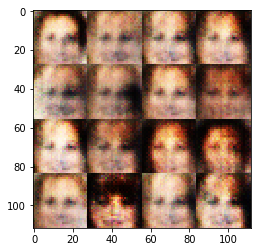

Step 1410, Epoch 1/1 Discriminator Loss: 1.2746... Geneator Loss: 0.8437
Step 1420, Epoch 1/1 Discriminator Loss: 1.4409... Geneator Loss: 0.7049
Step 1430, Epoch 1/1 Discriminator Loss: 1.3703... Geneator Loss: 0.8152
Step 1440, Epoch 1/1 Discriminator Loss: 1.3282... Geneator Loss: 0.7542
Step 1450, Epoch 1/1 Discriminator Loss: 1.4866... Geneator Loss: 0.7406
Step 1460, Epoch 1/1 Discriminator Loss: 1.2448... Geneator Loss: 0.8084
Step 1470, Epoch 1/1 Discriminator Loss: 1.3984... Geneator Loss: 0.8046
Step 1480, Epoch 1/1 Discriminator Loss: 1.3282... Geneator Loss: 0.7867
Step 1490, Epoch 1/1 Discriminator Loss: 1.3030... Geneator Loss: 0.8085
Step 1500, Epoch 1/1 Discriminator Loss: 1.5249... Geneator Loss: 0.6707


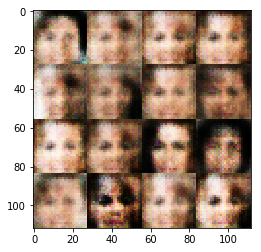

Step 1510, Epoch 1/1 Discriminator Loss: 1.3943... Geneator Loss: 0.7173
Step 1520, Epoch 1/1 Discriminator Loss: 1.2876... Geneator Loss: 0.8352
Step 1530, Epoch 1/1 Discriminator Loss: 1.3907... Geneator Loss: 0.7993
Step 1540, Epoch 1/1 Discriminator Loss: 1.4541... Geneator Loss: 0.7400
Step 1550, Epoch 1/1 Discriminator Loss: 1.2929... Geneator Loss: 0.8376
Step 1560, Epoch 1/1 Discriminator Loss: 1.4266... Geneator Loss: 0.7269
Step 1570, Epoch 1/1 Discriminator Loss: 1.3895... Geneator Loss: 0.7422
Step 1580, Epoch 1/1 Discriminator Loss: 1.3515... Geneator Loss: 0.7375
Step 1590, Epoch 1/1 Discriminator Loss: 1.4581... Geneator Loss: 0.7130
Step 1600, Epoch 1/1 Discriminator Loss: 1.3360... Geneator Loss: 0.7601


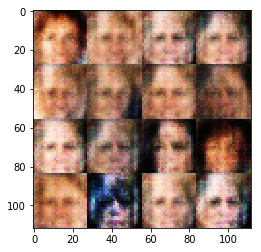

Step 1610, Epoch 1/1 Discriminator Loss: 1.3967... Geneator Loss: 0.7280
Step 1620, Epoch 1/1 Discriminator Loss: 1.2591... Geneator Loss: 0.7697
Step 1630, Epoch 1/1 Discriminator Loss: 1.3688... Geneator Loss: 0.7481
Step 1640, Epoch 1/1 Discriminator Loss: 1.4181... Geneator Loss: 0.6938
Step 1650, Epoch 1/1 Discriminator Loss: 1.3724... Geneator Loss: 0.7994
Step 1660, Epoch 1/1 Discriminator Loss: 1.3746... Geneator Loss: 0.7850
Step 1670, Epoch 1/1 Discriminator Loss: 1.3227... Geneator Loss: 0.8504
Step 1680, Epoch 1/1 Discriminator Loss: 1.3287... Geneator Loss: 0.7862
Step 1690, Epoch 1/1 Discriminator Loss: 1.2976... Geneator Loss: 0.8139
Step 1700, Epoch 1/1 Discriminator Loss: 1.4127... Geneator Loss: 0.6776


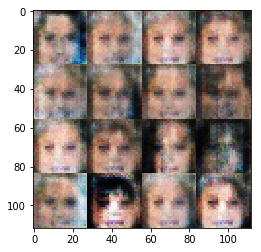

Step 1710, Epoch 1/1 Discriminator Loss: 1.3575... Geneator Loss: 0.7911
Step 1720, Epoch 1/1 Discriminator Loss: 1.4469... Geneator Loss: 0.6797
Step 1730, Epoch 1/1 Discriminator Loss: 1.3740... Geneator Loss: 0.7918
Step 1740, Epoch 1/1 Discriminator Loss: 1.3987... Geneator Loss: 0.7838
Step 1750, Epoch 1/1 Discriminator Loss: 1.3760... Geneator Loss: 0.7611
Step 1760, Epoch 1/1 Discriminator Loss: 1.3942... Geneator Loss: 0.6767
Step 1770, Epoch 1/1 Discriminator Loss: 1.1871... Geneator Loss: 0.9025
Step 1780, Epoch 1/1 Discriminator Loss: 1.3953... Geneator Loss: 0.7284
Step 1790, Epoch 1/1 Discriminator Loss: 1.3292... Geneator Loss: 0.7976
Step 1800, Epoch 1/1 Discriminator Loss: 1.3089... Geneator Loss: 0.8297


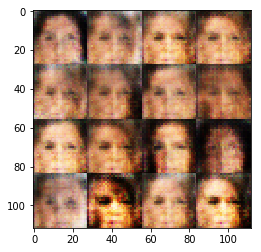

Step 1810, Epoch 1/1 Discriminator Loss: 1.4466... Geneator Loss: 0.7284
Step 1820, Epoch 1/1 Discriminator Loss: 1.4074... Geneator Loss: 0.7458
Step 1830, Epoch 1/1 Discriminator Loss: 1.4164... Geneator Loss: 0.7479
Step 1840, Epoch 1/1 Discriminator Loss: 1.2676... Geneator Loss: 0.8177
Step 1850, Epoch 1/1 Discriminator Loss: 1.4508... Geneator Loss: 0.7457
Step 1860, Epoch 1/1 Discriminator Loss: 1.3679... Geneator Loss: 0.7665
Step 1870, Epoch 1/1 Discriminator Loss: 1.3945... Geneator Loss: 0.7909
Step 1880, Epoch 1/1 Discriminator Loss: 1.3639... Geneator Loss: 0.8085
Step 1890, Epoch 1/1 Discriminator Loss: 1.3007... Geneator Loss: 0.8842
Step 1900, Epoch 1/1 Discriminator Loss: 1.3684... Geneator Loss: 0.7345


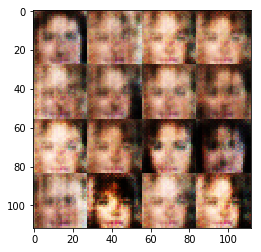

Step 1910, Epoch 1/1 Discriminator Loss: 1.5530... Geneator Loss: 0.6539
Step 1920, Epoch 1/1 Discriminator Loss: 1.2427... Geneator Loss: 0.7797
Step 1930, Epoch 1/1 Discriminator Loss: 1.3563... Geneator Loss: 0.7457
Step 1940, Epoch 1/1 Discriminator Loss: 1.3312... Geneator Loss: 0.8016
Step 1950, Epoch 1/1 Discriminator Loss: 1.4538... Geneator Loss: 0.7593
Step 1960, Epoch 1/1 Discriminator Loss: 1.2972... Geneator Loss: 0.8349
Step 1970, Epoch 1/1 Discriminator Loss: 1.3013... Geneator Loss: 0.7705
Step 1980, Epoch 1/1 Discriminator Loss: 1.4764... Geneator Loss: 0.7524
Step 1990, Epoch 1/1 Discriminator Loss: 1.4421... Geneator Loss: 0.6772
Step 2000, Epoch 1/1 Discriminator Loss: 1.4476... Geneator Loss: 0.7203


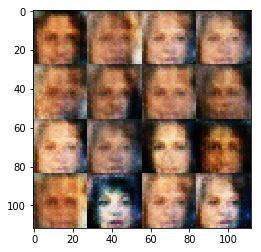

Step 2010, Epoch 1/1 Discriminator Loss: 1.3202... Geneator Loss: 0.7680
Step 2020, Epoch 1/1 Discriminator Loss: 1.3789... Geneator Loss: 0.7232
Step 2030, Epoch 1/1 Discriminator Loss: 1.2922... Geneator Loss: 0.8324
Step 2040, Epoch 1/1 Discriminator Loss: 1.4819... Geneator Loss: 0.6890
Step 2050, Epoch 1/1 Discriminator Loss: 1.4923... Geneator Loss: 0.6409
Step 2060, Epoch 1/1 Discriminator Loss: 1.2337... Geneator Loss: 0.7842
Step 2070, Epoch 1/1 Discriminator Loss: 1.3896... Geneator Loss: 0.7737
Step 2080, Epoch 1/1 Discriminator Loss: 1.4253... Geneator Loss: 0.6961
Step 2090, Epoch 1/1 Discriminator Loss: 1.4342... Geneator Loss: 0.7520
Step 2100, Epoch 1/1 Discriminator Loss: 1.3256... Geneator Loss: 0.7436


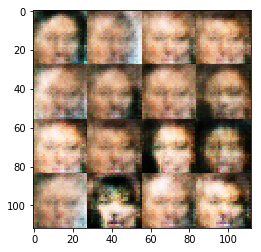

Step 2110, Epoch 1/1 Discriminator Loss: 1.4009... Geneator Loss: 0.7178
Step 2120, Epoch 1/1 Discriminator Loss: 1.3693... Geneator Loss: 0.7422
Step 2130, Epoch 1/1 Discriminator Loss: 1.3612... Geneator Loss: 0.7302
Step 2140, Epoch 1/1 Discriminator Loss: 1.3191... Geneator Loss: 0.7785
Step 2150, Epoch 1/1 Discriminator Loss: 1.3698... Geneator Loss: 0.7712
Step 2160, Epoch 1/1 Discriminator Loss: 1.3269... Geneator Loss: 0.7805
Step 2170, Epoch 1/1 Discriminator Loss: 1.3936... Geneator Loss: 0.6771
Step 2180, Epoch 1/1 Discriminator Loss: 1.3620... Geneator Loss: 0.7066
Step 2190, Epoch 1/1 Discriminator Loss: 1.5082... Geneator Loss: 0.7150
Step 2200, Epoch 1/1 Discriminator Loss: 1.2782... Geneator Loss: 0.8335


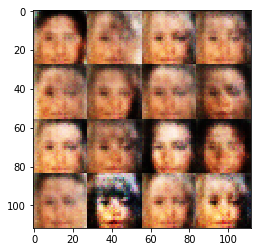

Step 2210, Epoch 1/1 Discriminator Loss: 1.5337... Geneator Loss: 0.7147
Step 2220, Epoch 1/1 Discriminator Loss: 1.3393... Geneator Loss: 0.7886
Step 2230, Epoch 1/1 Discriminator Loss: 1.3570... Geneator Loss: 0.7480
Step 2240, Epoch 1/1 Discriminator Loss: 1.3833... Geneator Loss: 0.6990
Step 2250, Epoch 1/1 Discriminator Loss: 1.2437... Geneator Loss: 0.8152
Step 2260, Epoch 1/1 Discriminator Loss: 1.4716... Geneator Loss: 0.7220
Step 2270, Epoch 1/1 Discriminator Loss: 1.3299... Geneator Loss: 0.7222
Step 2280, Epoch 1/1 Discriminator Loss: 1.2995... Geneator Loss: 0.7830
Step 2290, Epoch 1/1 Discriminator Loss: 1.4501... Geneator Loss: 0.7570
Step 2300, Epoch 1/1 Discriminator Loss: 1.3959... Geneator Loss: 0.7415


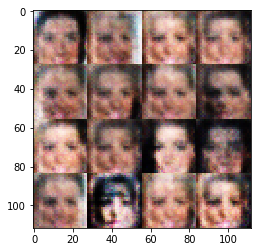

Step 2310, Epoch 1/1 Discriminator Loss: 1.4300... Geneator Loss: 0.6901
Step 2320, Epoch 1/1 Discriminator Loss: 1.4206... Geneator Loss: 0.7218
Step 2330, Epoch 1/1 Discriminator Loss: 1.4612... Geneator Loss: 0.6722
Step 2340, Epoch 1/1 Discriminator Loss: 1.3868... Geneator Loss: 0.7031
Step 2350, Epoch 1/1 Discriminator Loss: 1.3898... Geneator Loss: 0.7436
Step 2360, Epoch 1/1 Discriminator Loss: 1.3395... Geneator Loss: 0.7598
Step 2370, Epoch 1/1 Discriminator Loss: 1.3697... Geneator Loss: 0.7374
Step 2380, Epoch 1/1 Discriminator Loss: 1.3614... Geneator Loss: 0.7325
Step 2390, Epoch 1/1 Discriminator Loss: 1.3848... Geneator Loss: 0.8297
Step 2400, Epoch 1/1 Discriminator Loss: 1.4778... Geneator Loss: 0.6536


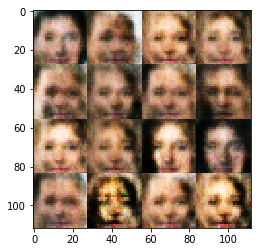

Step 2410, Epoch 1/1 Discriminator Loss: 1.3097... Geneator Loss: 0.7972
Step 2420, Epoch 1/1 Discriminator Loss: 1.5133... Geneator Loss: 0.7047
Step 2430, Epoch 1/1 Discriminator Loss: 1.3003... Geneator Loss: 0.7612
Step 2440, Epoch 1/1 Discriminator Loss: 1.3242... Geneator Loss: 0.7949
Step 2450, Epoch 1/1 Discriminator Loss: 1.2164... Geneator Loss: 0.7973
Step 2460, Epoch 1/1 Discriminator Loss: 1.4112... Geneator Loss: 0.7344
Step 2470, Epoch 1/1 Discriminator Loss: 1.3057... Geneator Loss: 0.8004
Step 2480, Epoch 1/1 Discriminator Loss: 1.3487... Geneator Loss: 0.8117
Step 2490, Epoch 1/1 Discriminator Loss: 1.3847... Geneator Loss: 0.7263
Step 2500, Epoch 1/1 Discriminator Loss: 1.4069... Geneator Loss: 0.6971


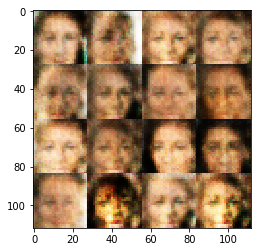

Step 2510, Epoch 1/1 Discriminator Loss: 1.3761... Geneator Loss: 0.7467
Step 2520, Epoch 1/1 Discriminator Loss: 1.4820... Geneator Loss: 0.7058
Step 2530, Epoch 1/1 Discriminator Loss: 1.3457... Geneator Loss: 0.7459
Step 2540, Epoch 1/1 Discriminator Loss: 1.3585... Geneator Loss: 0.7686
Step 2550, Epoch 1/1 Discriminator Loss: 1.3352... Geneator Loss: 0.7482
Step 2560, Epoch 1/1 Discriminator Loss: 1.4145... Geneator Loss: 0.7270
Step 2570, Epoch 1/1 Discriminator Loss: 1.3455... Geneator Loss: 0.7529
Step 2580, Epoch 1/1 Discriminator Loss: 1.4380... Geneator Loss: 0.7137
Step 2590, Epoch 1/1 Discriminator Loss: 1.3142... Geneator Loss: 0.7616
Step 2600, Epoch 1/1 Discriminator Loss: 1.2686... Geneator Loss: 0.8274


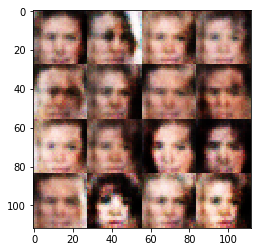

Step 2610, Epoch 1/1 Discriminator Loss: 1.3689... Geneator Loss: 0.7626
Step 2620, Epoch 1/1 Discriminator Loss: 1.3914... Geneator Loss: 0.7481
Step 2630, Epoch 1/1 Discriminator Loss: 1.3329... Geneator Loss: 0.7586
Step 2640, Epoch 1/1 Discriminator Loss: 1.4112... Geneator Loss: 0.7887
Step 2650, Epoch 1/1 Discriminator Loss: 1.2916... Geneator Loss: 0.8117
Step 2660, Epoch 1/1 Discriminator Loss: 1.4347... Geneator Loss: 0.6952
Step 2670, Epoch 1/1 Discriminator Loss: 1.4217... Geneator Loss: 0.6731
Step 2680, Epoch 1/1 Discriminator Loss: 1.3425... Geneator Loss: 0.7769
Step 2690, Epoch 1/1 Discriminator Loss: 1.3676... Geneator Loss: 0.6822
Step 2700, Epoch 1/1 Discriminator Loss: 1.2872... Geneator Loss: 0.8135


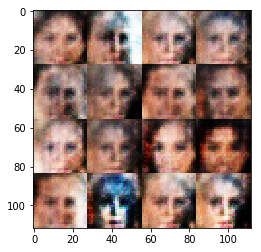

Step 2710, Epoch 1/1 Discriminator Loss: 1.3822... Geneator Loss: 0.7205
Step 2720, Epoch 1/1 Discriminator Loss: 1.4471... Geneator Loss: 0.7303
Step 2730, Epoch 1/1 Discriminator Loss: 1.4407... Geneator Loss: 0.6697
Step 2740, Epoch 1/1 Discriminator Loss: 1.3993... Geneator Loss: 0.7690
Step 2750, Epoch 1/1 Discriminator Loss: 1.4685... Geneator Loss: 0.6272
Step 2760, Epoch 1/1 Discriminator Loss: 1.3519... Geneator Loss: 0.7255
Step 2770, Epoch 1/1 Discriminator Loss: 1.4235... Geneator Loss: 0.6928
Step 2780, Epoch 1/1 Discriminator Loss: 1.4122... Geneator Loss: 0.6570
Step 2790, Epoch 1/1 Discriminator Loss: 1.4419... Geneator Loss: 0.7553
Step 2800, Epoch 1/1 Discriminator Loss: 1.4114... Geneator Loss: 0.7044


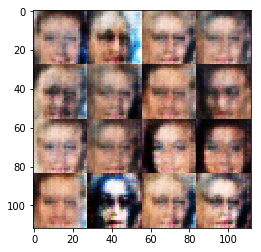

Step 2810, Epoch 1/1 Discriminator Loss: 1.3679... Geneator Loss: 0.7418
Step 2820, Epoch 1/1 Discriminator Loss: 1.3778... Geneator Loss: 0.7298
Step 2830, Epoch 1/1 Discriminator Loss: 1.4056... Geneator Loss: 0.6943
Step 2840, Epoch 1/1 Discriminator Loss: 1.3477... Geneator Loss: 0.7428
Step 2850, Epoch 1/1 Discriminator Loss: 1.4160... Geneator Loss: 0.6689
Step 2860, Epoch 1/1 Discriminator Loss: 1.4135... Geneator Loss: 0.7134
Step 2870, Epoch 1/1 Discriminator Loss: 1.4368... Geneator Loss: 0.6817
Step 2880, Epoch 1/1 Discriminator Loss: 1.3460... Geneator Loss: 0.7524
Step 2890, Epoch 1/1 Discriminator Loss: 1.4246... Geneator Loss: 0.7085
Step 2900, Epoch 1/1 Discriminator Loss: 1.4474... Geneator Loss: 0.6866


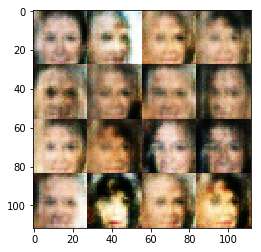

Step 2910, Epoch 1/1 Discriminator Loss: 1.3646... Geneator Loss: 0.7157
Step 2920, Epoch 1/1 Discriminator Loss: 1.3607... Geneator Loss: 0.7546
Step 2930, Epoch 1/1 Discriminator Loss: 1.3415... Geneator Loss: 0.7204
Step 2940, Epoch 1/1 Discriminator Loss: 1.3946... Geneator Loss: 0.6702
Step 2950, Epoch 1/1 Discriminator Loss: 1.3403... Geneator Loss: 0.7104
Step 2960, Epoch 1/1 Discriminator Loss: 1.4094... Geneator Loss: 0.7139
Step 2970, Epoch 1/1 Discriminator Loss: 1.3912... Geneator Loss: 0.7140
Step 2980, Epoch 1/1 Discriminator Loss: 1.3318... Geneator Loss: 0.7065
Step 2990, Epoch 1/1 Discriminator Loss: 1.4418... Geneator Loss: 0.7193
Step 3000, Epoch 1/1 Discriminator Loss: 1.4248... Geneator Loss: 0.6734


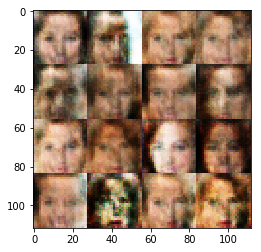

Step 3010, Epoch 1/1 Discriminator Loss: 1.3630... Geneator Loss: 0.7465
Step 3020, Epoch 1/1 Discriminator Loss: 1.3785... Geneator Loss: 0.7089
Step 3030, Epoch 1/1 Discriminator Loss: 1.4444... Geneator Loss: 0.6790
Step 3040, Epoch 1/1 Discriminator Loss: 1.3940... Geneator Loss: 0.7320
Step 3050, Epoch 1/1 Discriminator Loss: 1.4364... Geneator Loss: 0.6913
Step 3060, Epoch 1/1 Discriminator Loss: 1.4218... Geneator Loss: 0.6789
Step 3070, Epoch 1/1 Discriminator Loss: 1.3001... Geneator Loss: 0.7517
Step 3080, Epoch 1/1 Discriminator Loss: 1.4157... Geneator Loss: 0.7546
Step 3090, Epoch 1/1 Discriminator Loss: 1.3846... Geneator Loss: 0.7474
Step 3100, Epoch 1/1 Discriminator Loss: 1.3914... Geneator Loss: 0.7185


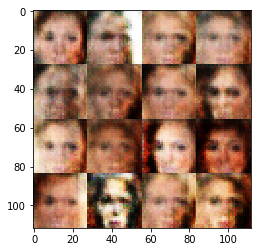

Step 3110, Epoch 1/1 Discriminator Loss: 1.4426... Geneator Loss: 0.6516
Step 3120, Epoch 1/1 Discriminator Loss: 1.3820... Geneator Loss: 0.6689
Step 3130, Epoch 1/1 Discriminator Loss: 1.4278... Geneator Loss: 0.6573
Step 3140, Epoch 1/1 Discriminator Loss: 1.3663... Geneator Loss: 0.7153
Step 3150, Epoch 1/1 Discriminator Loss: 1.4426... Geneator Loss: 0.7042
Step 3160, Epoch 1/1 Discriminator Loss: 1.4142... Geneator Loss: 0.6987
all done!


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = .5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode
                        #train_discriminator_every_N_steps = 2
                           )

print('all done!')

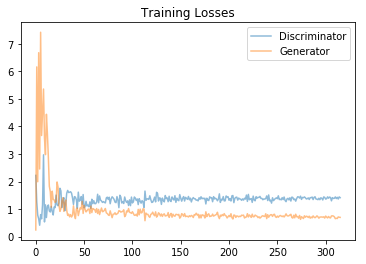

In [28]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.